In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import re

# Amazon bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -70, -50

sif_amazon = []
time_list = []

data_dir = "SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  # Extract YYYYMM
        year = int(date_str[:4])  
        month = int(date_str[4:6])  
    if year == 2018:
        continue
    else:

        file_path = os.path.join(data_dir, file)
        
        ds = xr.open_dataset(file_path)
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  # Shape: [time, lat, lon]
        time_list.append(f"{year}-{month:02d}")

# Convert to numpy array
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

# Group into years
years = sorted(set(int(t.split("-")[0]) for t in time_list))

num_years = len(years)

# Initialize an empty array with NaNs
sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)

# Fill in available months
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  # Get year index
    month_idx = i % 12  # Get month index
    sif_monthly[year_idx, month_idx] = month_data  # Assign data

print("Fixed sif_monthly shape:", sif_monthly.shape)
# solar_induced_fluorescence_uncertainty         (time, latitude, longitude) float32 537MB .
#solar_induced_fluorescence_uncertainty_weight  (time, latitude, longitude) float32 537MB ...

Fixed sif_monthly shape: (3, 12, 911, 910)


In [7]:
import numpy as np
import pandas as pd

# Compute climatology: Average across years per month (ignoring NaNs)
climatology = np.nanmean(sif_monthly, axis=0)  

# Compute monthly means: Average over spatial dimensions
monthly_means = np.nanmean(climatology, axis=(1, 2))  # Shape: (12,)

# Compute overall mean SIF across all months
overall_mean_sif = np.nanmean(monthly_means)

# Create a climatology table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': np.round(monthly_means, 3)  # Rounded to 3 decimals
})

print("Monthly Climatology Summary:")
print(climatology_table)

print("\nOverall Mean SIF:", round(overall_mean_sif, 3))

Monthly Climatology Summary:
        Month  Avg SIF
0     January    1.449
1    February    1.388
2       March    1.317
3       April    1.304
4         May    1.197
5        June    1.140
6        July    1.109
7      August    1.076
8   September    1.073
9     October    1.157
10   November    1.329
11   December    1.504

Overall Mean SIF: 1.254


/tmp/ipykernel_6914/4122819461.py:5: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(sif_monthly, axis=0)


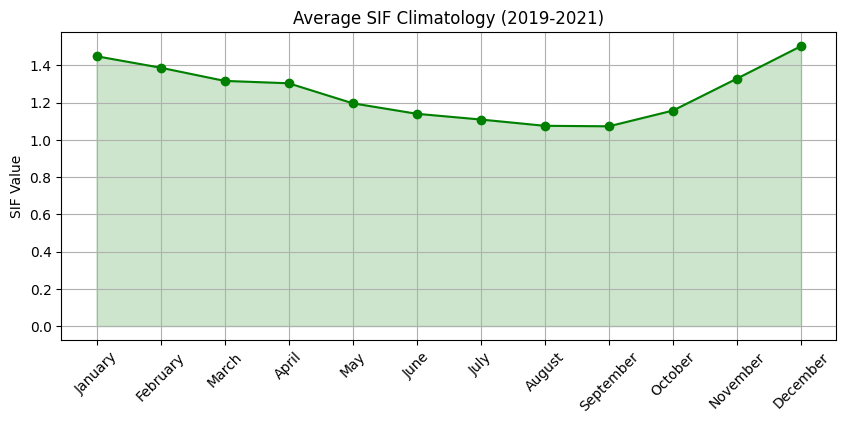

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, marker='o', color='green')
plt.fill_between(months, monthly_means, alpha=0.2, color='green')
plt.title("Average SIF Climatology (2019-2021)")
plt.ylabel("SIF Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

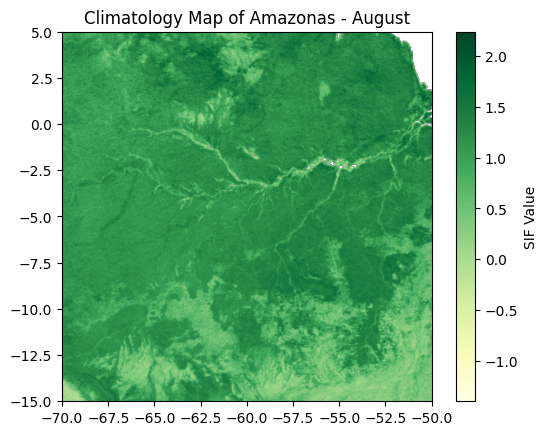

In [27]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

In [ ]:
# Compute Climatology Statistics
climatology_mean = np.nanmean(sif_monthly, axis=0)  # Monthly means [12, lat, lon]
climatology_std = np.nanstd(sif_monthly, axis=0)    # Monthly stds [12, lat, lon]

# Handle pixels with zero variability (avoid division by zero)
climatology_std[climatology_std == 0] = 1.0

# Normalize Data
sif_normalized = np.empty_like(sif_amazon)
for t in range(sif_amazon.shape[0]):
    month_idx = t % 12  # Which month (0-11)
    sif_normalized[t] = (sif_amazon[t] - climatology_mean[month_idx]) / climatology_std[month_idx]

# Prepare Sequences for Autoencoder (12-month windows)
sequence_length = 12
num_sequences = 3  # 11 years of data

# Create input sequences: [num_sequences, sequence_length, lat, lon, 1]
input_sequences = np.stack([sif_normalized[i*12:(i+1)*12] for i in range(num_sequences)], axis=0)
input_sequences = input_sequences[..., np.newaxis]  # Add channel dimension

#Autoencoder architecture
input_seq = Input(shape=(sequence_length, 911, 910, 1))

# Encoder
x = ConvLSTM2D(32, (3,3), activation='tanh', padding='same', 
               return_sequences=True, kernel_regularizer=l2(1e-4))(input_seq)
x = BatchNormalization()(x)

x = ConvLSTM2D(16, (3,3), activation='tanh', padding='same', 
               return_sequences=True)(x)
x = BatchNormalization()(x)

# Bottleneck with Attention to Spatial Patterns
x = ConvLSTM2D(8, (3,3), activation='tanh', padding='same', 
               return_sequences=True)(x)

# Decoder with Residual Connections
decoder = ConvLSTM2D(16, (3,3), activation='tanh', padding='same', 
                    return_sequences=True)(x)
decoder = BatchNormalization()(decoder)
decoder = ConvLSTM2D(32, (3,3), activation='tanh', padding='same', 
                    return_sequences=True)(decoder)

# Final Reconstruction with Pixel-wise Scaling
decoded = TimeDistributed(
    Conv2D(1, (3,3), activation='linear', padding='same',
           kernel_initializer='orthogonal'))(decoder)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train with Normalized Data
autoencoder.fit(input_sequences, input_sequences,
                epochs=50,
                batch_size=4,
                validation_split=0.2)

# Anomaly Detection (Example)
reconstructions = autoencoder.predict(input_sequences)
mse = np.mean((input_sequences - reconstructions)**2, axis=(1,2,3,4))

# Convert MSE back to original space
anomaly_scores = mse * (climatology_std**2).mean()  # Weight by average variance

/tmp/ipykernel_4485/1755275678.py:2: RuntimeWarning: Mean of empty slice
  climatology_mean = np.nanmean(sif_monthly, axis=0)  # Monthly means [12, lat, lon]


Epoch 1/50


2025-04-01 10:41:59.852134: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 79584960 exceeds 10% of free system memory.
2025-04-01 10:41:59.943149: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 79584960 exceeds 10% of free system memory.
